<a href="https://colab.research.google.com/github/saikiranmai2112/DA-Internship/blob/main/Cybersecurity_Suspicious_web_threat_interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:**

The CloudWatch Traffic web Attack dataset contains network traffic logs, whcich include various attributes such as data flow, request size, source/destination details, and security-related metadata.

The primary objective of analyzing this dataset is to identify potential security threats and anomalies in web traffic and optimize network performance.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
# Define file path
file_path = "/content/CloudWatch_Traffic_Web_Attack.csv"

In [ ]:
# Load csv file into a DataFrame
df = pd.read_csv(file_path)

In [ ]:
# Display the first few rows of the dataset
print("First 5 rows:")
print(df.head())

First 5 rows:
   bytes_in  bytes_out         creation_time  ...     source.name                  time detection_types
0      5602      12990  2024-04-25T23:00:00Z  ...  prod_webserver  2024-04-25T23:00:00Z        waf_rule
1     30912      18186  2024-04-25T23:00:00Z  ...  prod_webserver  2024-04-25T23:00:00Z        waf_rule
2     28506      13468  2024-04-25T23:00:00Z  ...  prod_webserver  2024-04-25T23:00:00Z        waf_rule
3     30546      14278  2024-04-25T23:00:00Z  ...  prod_webserver  2024-04-25T23:00:00Z        waf_rule
4      6526      13892  2024-04-25T23:00:00Z  ...  prod_webserver  2024-04-25T23:00:00Z        waf_rule

[5 rows x 16 columns]


In [ ]:
# Display basic information about the dataset
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    objec

In [ ]:
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
           bytes_in     bytes_out  response.code  dst_port
count  2.820000e+02  2.820000e+02          282.0     282.0
mean   1.199390e+06  8.455429e+04          200.0     443.0
std    4.149312e+06  2.549279e+05            0.0       0.0
min    4.000000e+01  4.400000e+01          200.0     443.0
25%    5.381500e+03  1.114200e+04          200.0     443.0
50%    1.318200e+04  1.379950e+04          200.0     443.0
75%    3.083300e+04  2.627950e+04          200.0     443.0
max    2.520779e+07  1.561220e+06          200.0     443.0


In [ ]:
# Display column names
print("\nColumn Names:")
print(df.columns)


Column Names:
Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types'],
      dtype='object')


**Data Preprocessing**

* Datetime Parsing: Converting timestamps(creation_time, end_time) into datetime format.  
* Handling Categroical Data: Encoding categorical columns (attack_type, risk_level) using LabelEncoder().
* Feature Scaling: Using StandardScaler() to normalize numerical columns
* Missing Data Handling: Check for null values and imputing/remediate them accordingly.

In [ ]:
# Handling missing values
df = df.dropna() # Drop rows with missing values

In [ ]:
df.ffill(inplace=True)

In [ ]:
# Convert categorical columns to lower case
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [ ]:
# Remove duplicates
df = df.drop_duplicates()

In [ ]:
df.fillna(df['bytes_in'].median(), inplace=True)

In [ ]:
df.dropna(subset=['src_ip', 'dst_ip'], inplace=True)

In [ ]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# Display cleaned dataset info
print("\nCleaned Dataset Info:")
df.info()


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   bytes_in             282 non-null    int64         
 1   bytes_out            282 non-null    int64         
 2   creation_time        282 non-null    datetime64[ns]
 3   end_time             282 non-null    datetime64[ns]
 4   src_ip               282 non-null    object        
 5   src_ip_country_code  282 non-null    object        
 6   protocol             282 non-null    object        
 7   response.code        282 non-null    int64         
 8   dst_port             282 non-null    int64         
 9   dst_ip               282 non-null    object        
 10  rule_names           282 non-null    object        
 11  observation_name     282 non-null    object        
 12  source.meta          282 non-null    object        
 13  source.name 

**Data Transformation**

Normalization and Scaling

In [ ]:
numeric_cols =df.select_dtypes(include=['number']).columns

In [ ]:
# Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numeric_cols] = minmax_scaler.fit_transform(df[numeric_cols])

In [ ]:
# Standardization (z-score scaling)
standard_scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[numeric_cols] = standard_scaler.fit_transform(df[numeric_cols])

Encoding categorical data

In [ ]:
# Encoding categorical data
categorical_cols = df.select_dtypes(include=['object']).columns

In [ ]:
# One-Hot Encoding
df_one_hot = pd.get_dummies(df, columns=categorical_cols)

In [ ]:
# Label Encoding
label_encoders = {}
df_label_encoded = df.copy()
for col in categorical_cols:
  le = LabelEncoder()
  df_label_encoded[col] = le.fit_transform(df[col])
  label_encoders[col] = le

Feature Engineering

In [ ]:
# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
df_poly = df.copy()
df_poly_features = poly.fit_transform(df[numeric_cols])
df_poly = pd.DataFrame(df_poly_features, columns=poly.get_feature_names_out(numeric_cols))

In [ ]:
# Binning
for col in numeric_cols:
  try:
      df[f'{col}_binned'] = pd.qcut(df[col], q=4, labels=["Low", "Medium", "High", "Very High"], duplicates='drop')
  except ValueError as e:
      print(f"skipping binning for {col}: {e}")

skipping binning for response.code: Bin labels must be one fewer than the number of bin edges
skipping binning for dst_port: Bin labels must be one fewer than the number of bin edges


In [ ]:
# Display cleaned dataset
print("\nCleaned Dataset Info:")
df.info()


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   bytes_in             282 non-null    int64         
 1   bytes_out            282 non-null    int64         
 2   creation_time        282 non-null    datetime64[ns]
 3   end_time             282 non-null    datetime64[ns]
 4   src_ip               282 non-null    object        
 5   src_ip_country_code  282 non-null    object        
 6   protocol             282 non-null    object        
 7   response.code        282 non-null    int64         
 8   dst_port             282 non-null    int64         
 9   dst_ip               282 non-null    object        
 10  rule_names           282 non-null    object        
 11  observation_name     282 non-null    object        
 12  source.meta          282 non-null    object        
 13  source.name 

In [ ]:
# Standardization for bytes_in and bytes_out
if 'bytes_in' in df.columns and 'bytes_out' in df.columns:
  standard_scaler = StandardScaler()
  df[['bytes_in', 'bytes_out']] = standard_scaler.fit_transform(df[['bytes_in', 'bytes_out']])

In [ ]:
# One-hot coding for scr_ip_country_code
if 'scr_ip_country_code' in df.columns:
  df = pd.get_dummies(df, columns=['src_ip_country_code'], prefix='country')

In [ ]:
# Creating new feature for connection duration
if 'creation_time' in df.columns and 'end_time' in df.columns:
  df['creation_time'] = pd.to_datetime(df['creation_time'])
  df['end_time'] = pd.to_datetime(df['end_time'])
  df['connection_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

In [ ]:
# Display transformed data
print("\nTransformed Data:")
df.head()


Transformed Data:


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,bytes_in_binned,bytes_out_binned,connection_duration
0,-0.288219,-0.281223,2024-04-25 23:00:00,2024-04-25 23:10:00,147.161.161.82,ae,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00,waf_rule,Medium,Medium,600.0
1,-0.282108,-0.260804,2024-04-25 23:00:00,2024-04-25 23:10:00,165.225.33.6,us,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00,waf_rule,Very High,High,600.0
2,-0.282689,-0.279344,2024-04-25 23:00:00,2024-04-25 23:10:00,165.225.212.255,ca,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00,waf_rule,High,Medium,600.0
3,-0.282197,-0.276161,2024-04-25 23:00:00,2024-04-25 23:10:00,136.226.64.114,us,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00,waf_rule,High,High,600.0
4,-0.287996,-0.277678,2024-04-25 23:00:00,2024-04-25 23:10:00,165.225.240.79,nl,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00,waf_rule,Medium,High,600.0


**Exploratory Data Analysis**: This helps us understand the dataset, detect patterns, and identify potential anomalies before applying machine learning models.

Descriptive Statistics

In [ ]:
# Descriptive statistics
print("\nDescriptive Statistics:")
descriptive_stats = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Median": df[numeric_cols].median(),
    "Mode": df[numeric_cols].mode().iloc[0] if not df[numeric_cols].mode().empty else np.nan,
    "Min": df[numeric_cols].min(),
    "Max": df[numeric_cols].max(),
    "Range": df[numeric_cols].max() - df[numeric_cols].min(),
    "Q1": df[numeric_cols].quantile(0.25),
    "Q2 (Median)": df[numeric_cols].quantile(0.50),
    "Q3": df[numeric_cols].quantile(0.75),
    "Standard Deviation": df[numeric_cols].std()
    })
print(descriptive_stats)


Descriptive Statistics:
                       Mean      Median        Mode  ...  Q2 (Median)          Q3  Standard Deviation
bytes_in      -1.259828e-17   -0.286389   -0.288307  ...    -0.286389   -0.282127            1.001778
bytes_out     -1.259828e-17   -0.278042   -0.286394  ...    -0.278042   -0.229000            1.001778
response.code  2.000000e+02  200.000000  200.000000  ...   200.000000  200.000000            0.000000
dst_port       4.430000e+02  443.000000  443.000000  ...   443.000000  443.000000            0.000000

[4 rows x 10 columns]


In [ ]:
# Correlation Analysis
print("\nCorrelation Analysis:")
correlation_matrix = df[numeric_cols].corr()
print(correlation_matrix)


Correlation Analysis:
               bytes_in  bytes_out  response.code  dst_port
bytes_in       1.000000   0.997705            NaN       NaN
bytes_out      0.997705   1.000000            NaN       NaN
response.code       NaN        NaN            NaN       NaN
dst_port            NaN        NaN            NaN       NaN


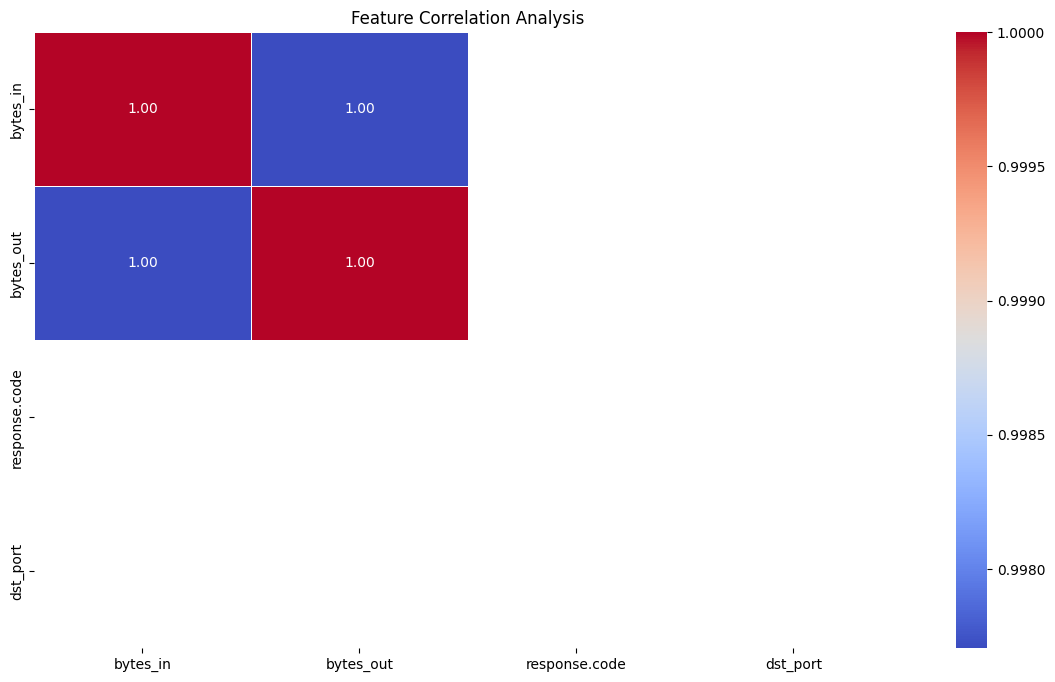

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Analysis")
plt.show()

* This correlation map helps identify correlated variables that may influence traffic behavior  
* This is useful for feature selection in machine learning models.

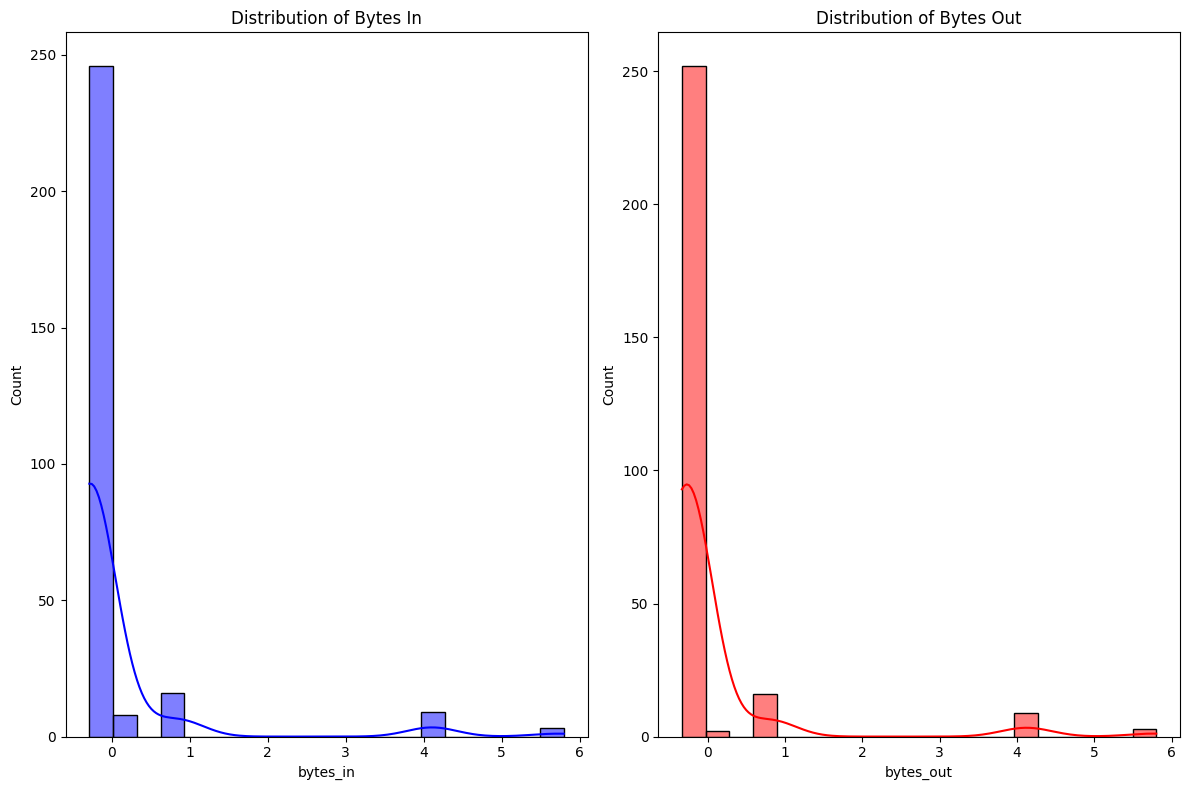

In [ ]:
# Distribution of Bytes In and Bytes Out
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.histplot(df['bytes_in'], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Bytes In")

sns.histplot(df['bytes_out'], bins=20, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Bytes Out")

plt.tight_layout()
plt.show()

* Shows the distribution of incoming and outgoing data.
*  This helps identify patterns in data flow and detect anomalies.



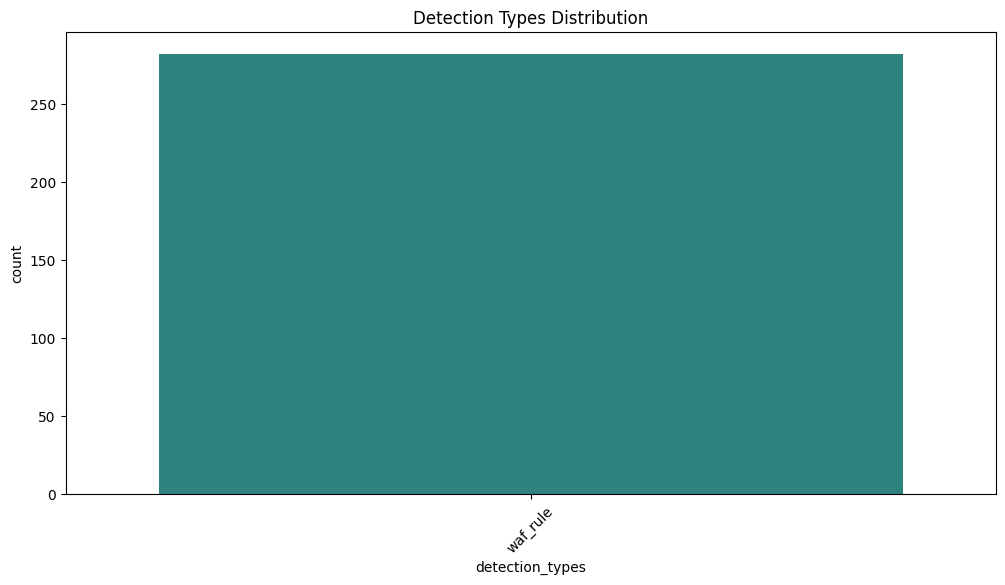

In [ ]:
# Count Plot of Detection Type (Attack Categories)
if 'detection_types' in df.columns:
  plt.figure(figsize=(12, 6))
  sns.countplot(x=df['detection_types'],hue=df['detection_types'] , palette="viridis", legend=False)
  plt.title("Detection Types Distribution")
  plt.xticks(rotation=45)
  plt.show()

* Visualizes the frequency of each detection type.
* This helps in understanding the most common types of web attacks detecteed in the dataset.

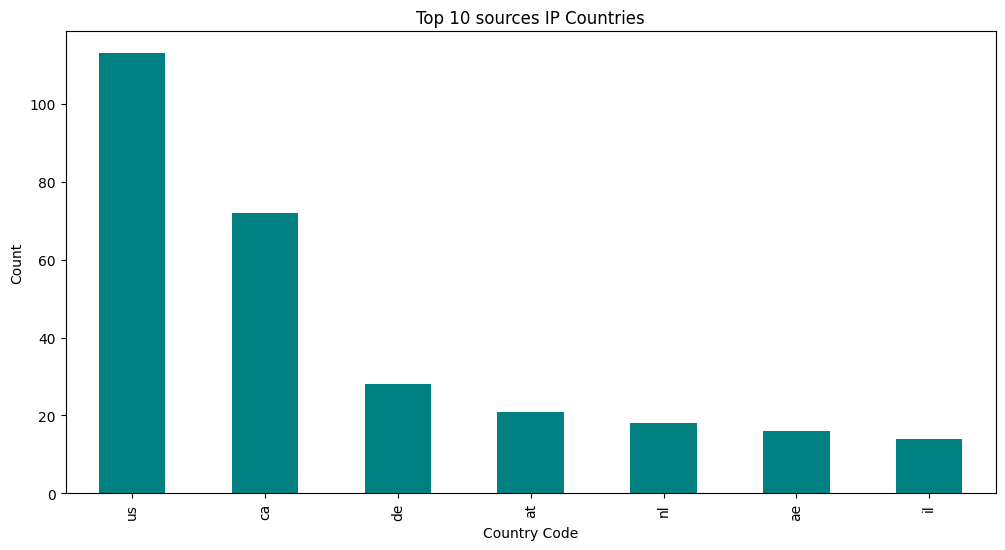

In [ ]:
# Top 10 source IP countries in Traffic
if 'src_ip_country_code' in df.columns:
  plt.figure(figsize=(12, 6))
  df['src_ip_country_code'].value_counts().nlargest(10).plot(kind='bar', color="teal")
  plt.title("Top 10 sources IP Countries")
  plt.xlabel("Country Code")
  plt.ylabel("Count")
  plt.show()

* Bar chart displays the top 10 countries from which traffic originates.
* Useful for detecting geographic patterns in attacks and identifying potential threat sources.

<Figure size 1200x600 with 0 Axes>

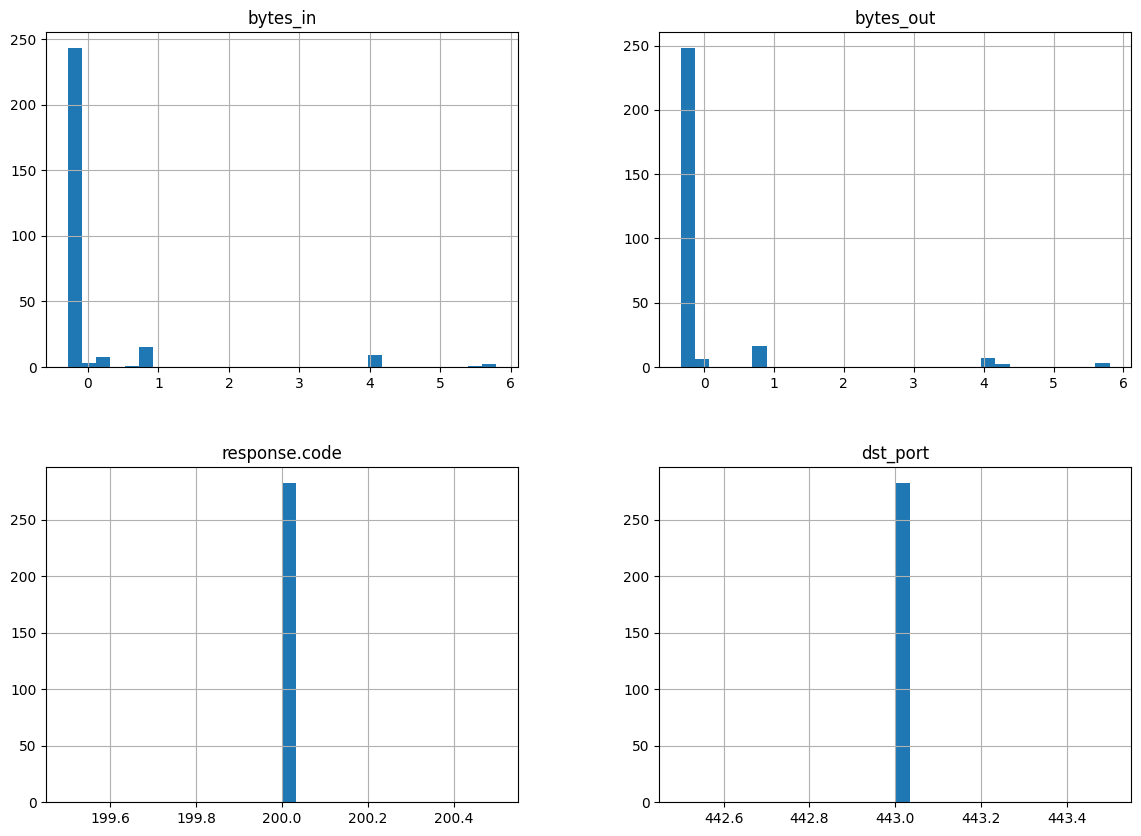

In [ ]:
# Plot Distribution of numerical values
plt.figure(figsize=(12, 6))
df[numeric_cols].hist(bins=30, figsize=(14, 10))
plt.show()

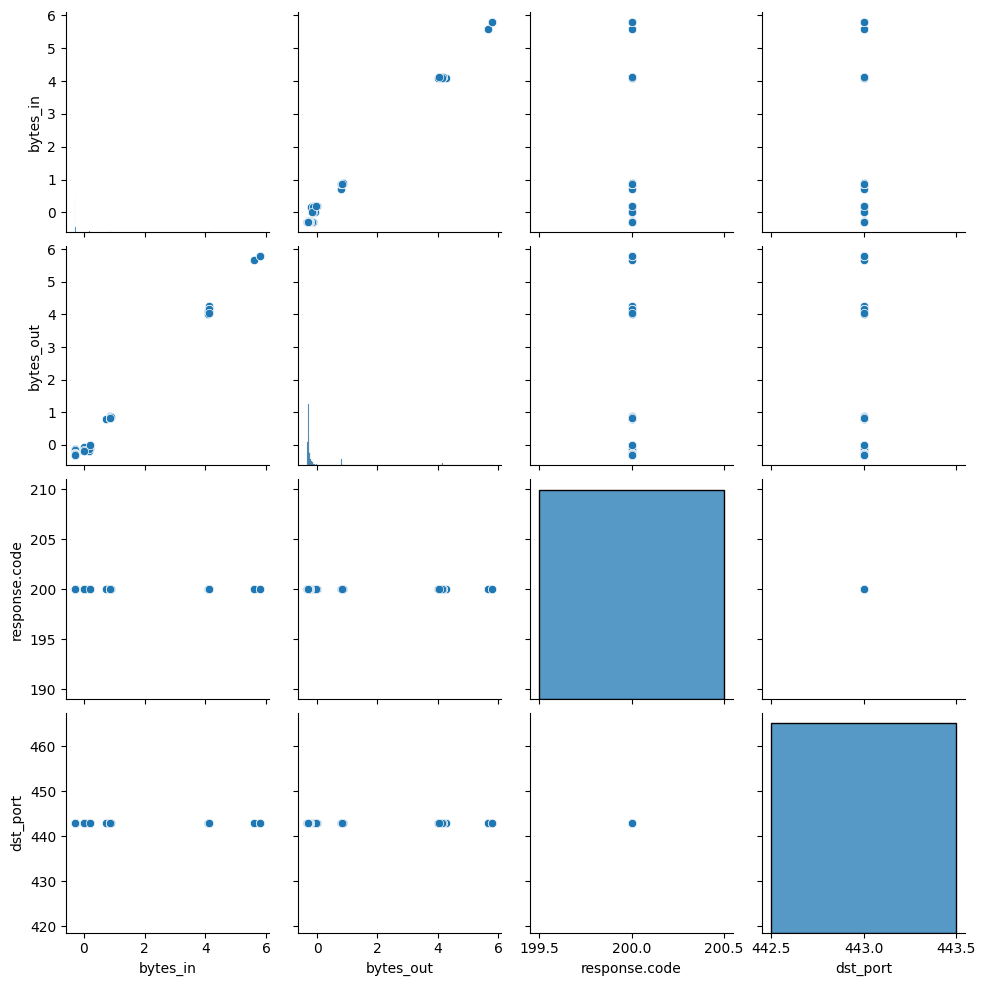

In [ ]:
# Pairplot for numerical columns
sns.pairplot(df[numeric_cols])
plt.show()

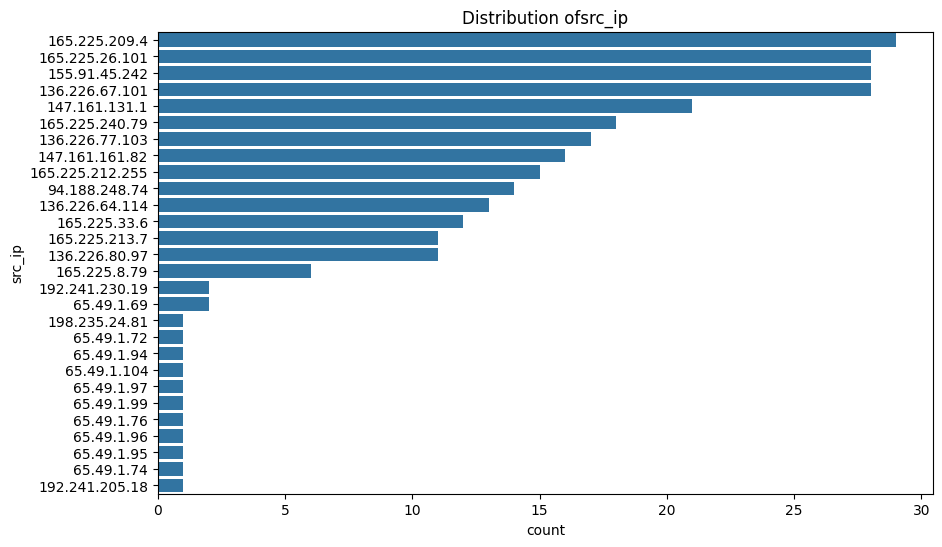

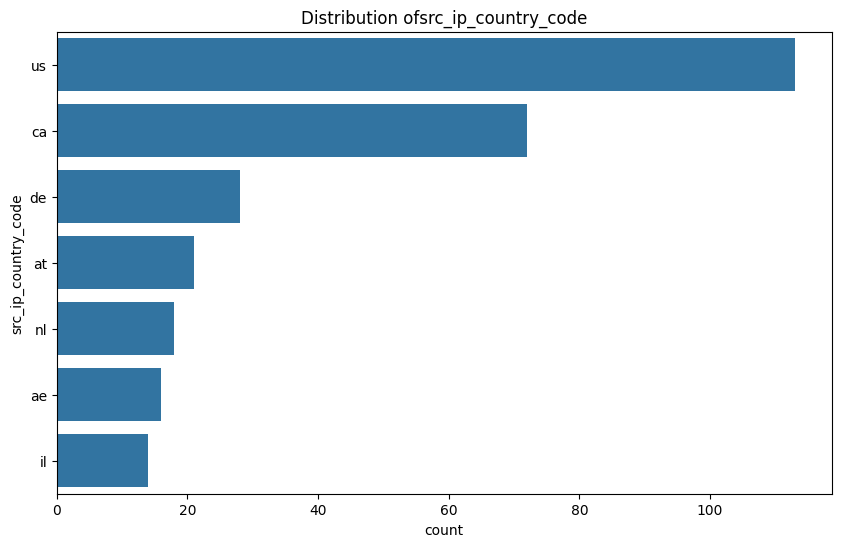

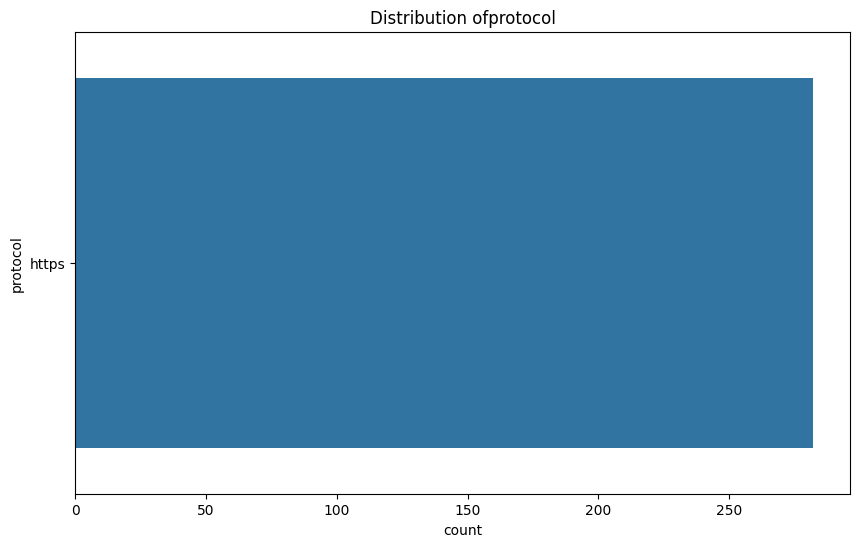

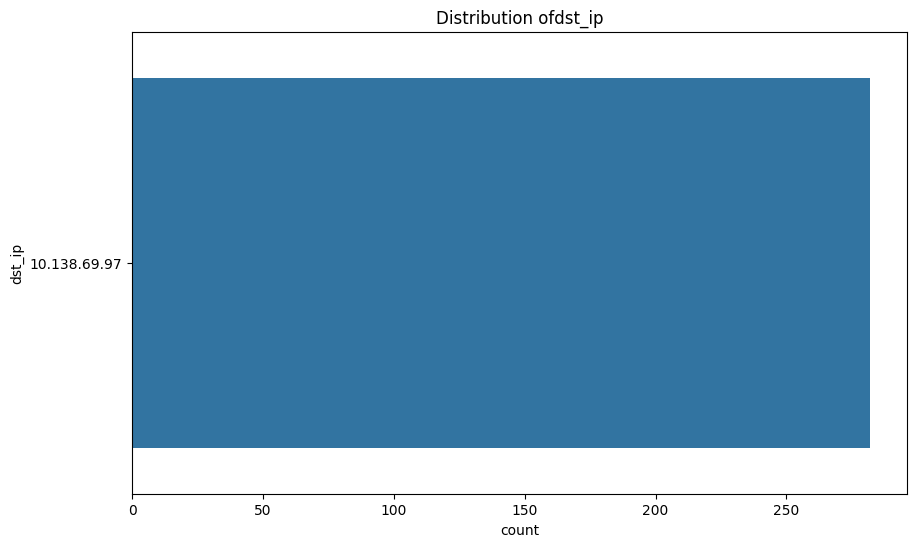

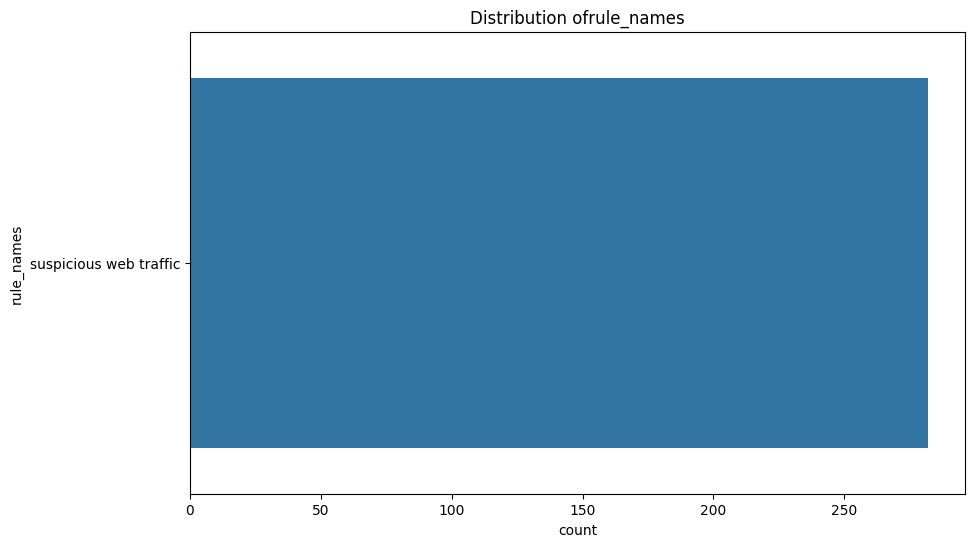

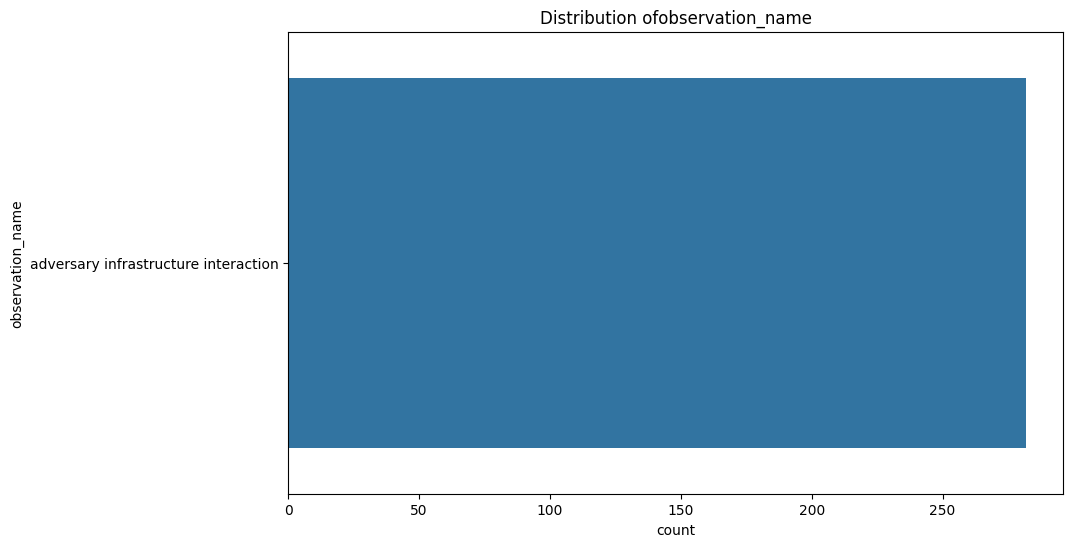

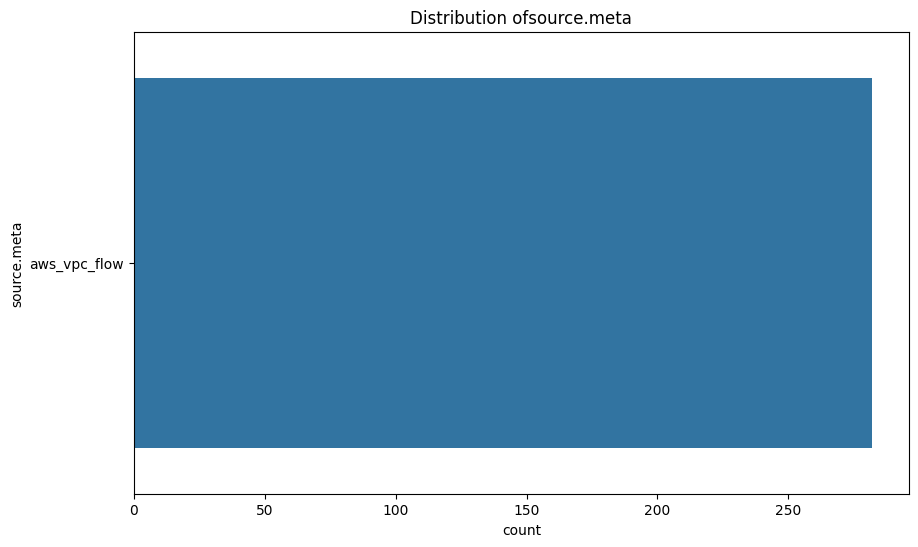

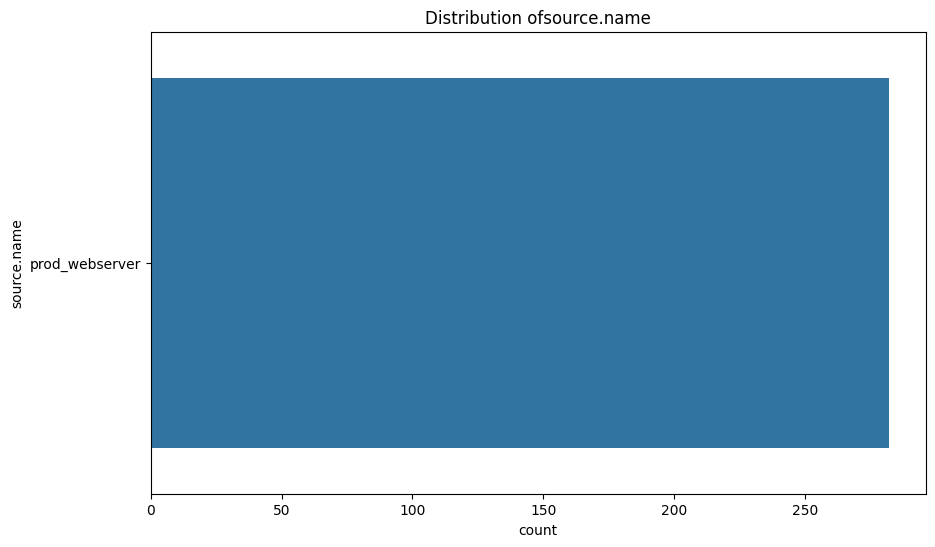

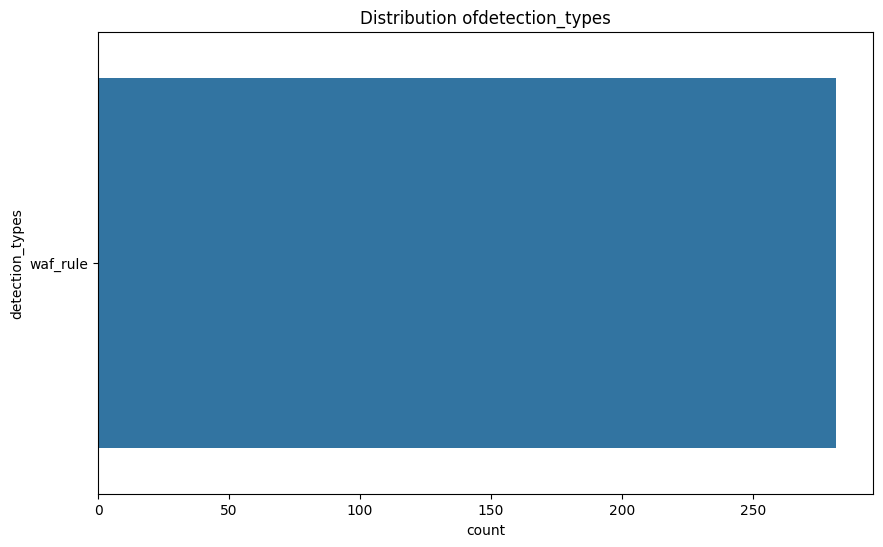

In [ ]:
# Countplot for categorical columns
for col in categorical_cols:
  plt.figure(figsize=(10, 6))
  sns.countplot(y=df[col], order=df[col].value_counts().index)
  plt.title(f"Distribution of{col}")
  plt.show()


Distribution Analysis of key features:


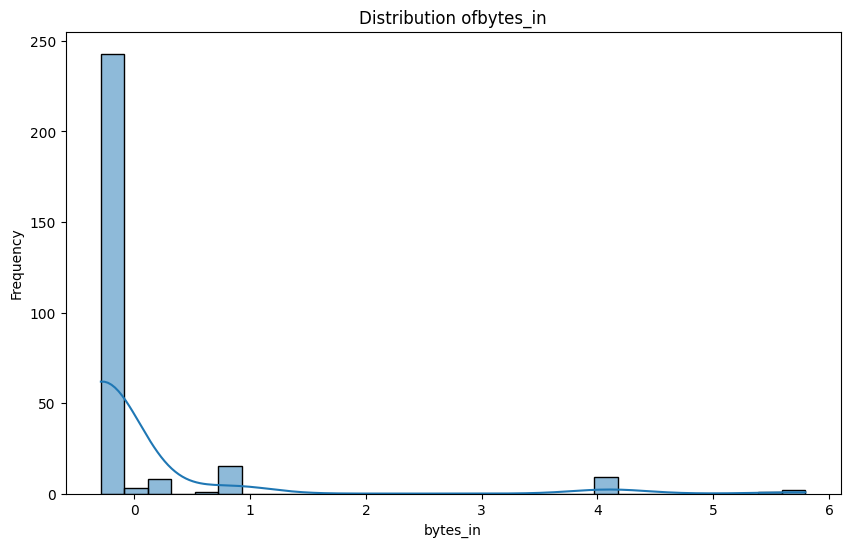

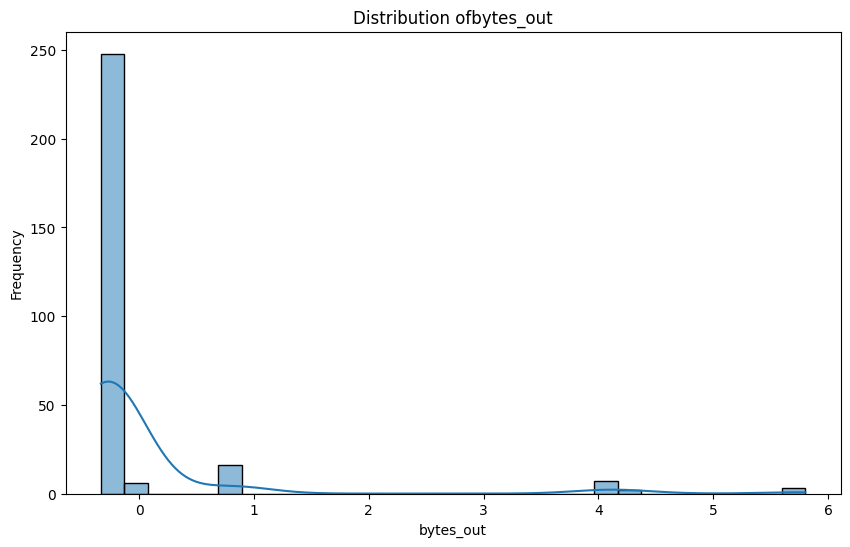

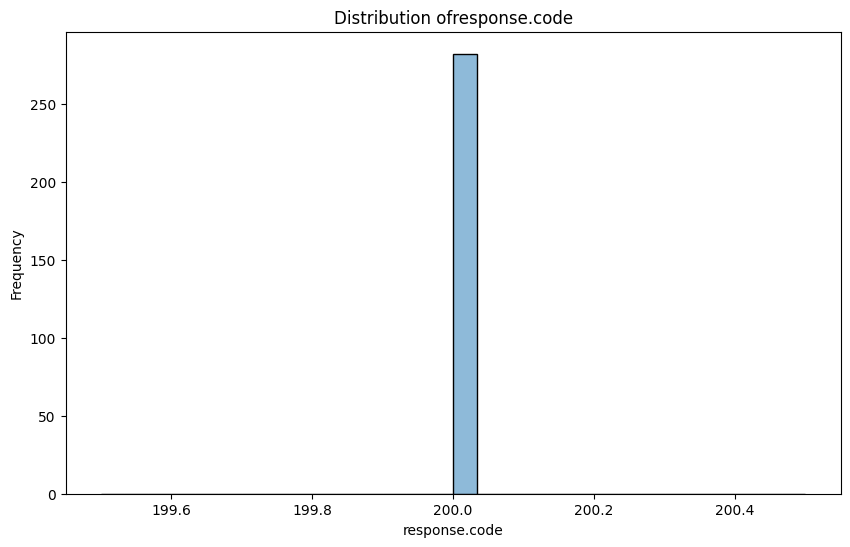

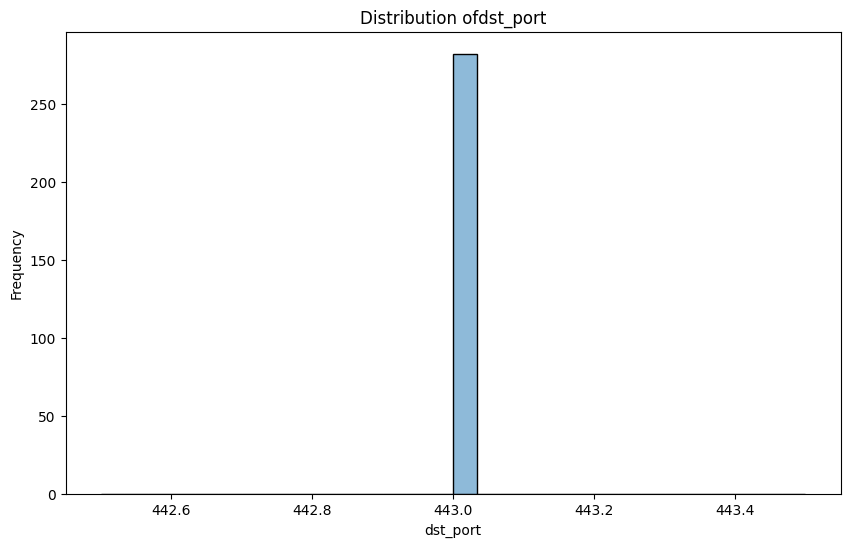

In [ ]:
# Distribution analysis of key features
print("\nDistribution Analysis of key features:")
for col in numeric_cols:
  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, bins=30)
  plt.title(f"Distribution of{col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.show()

**Data Visualization**

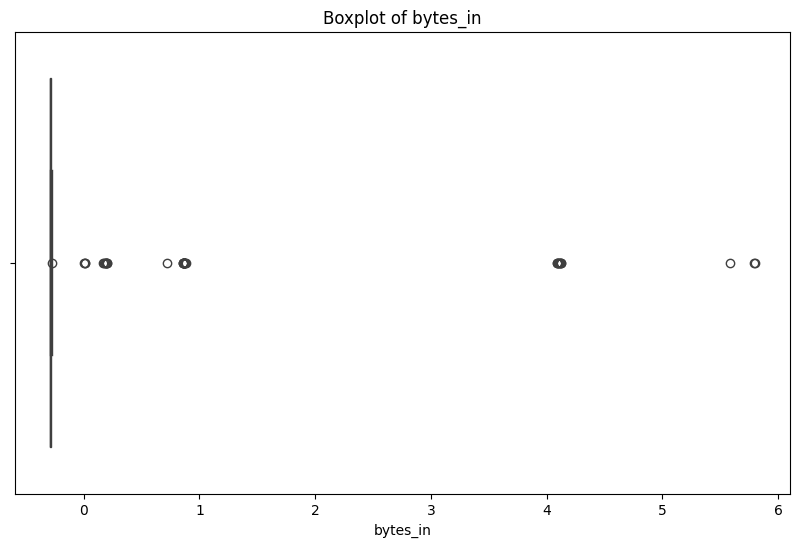

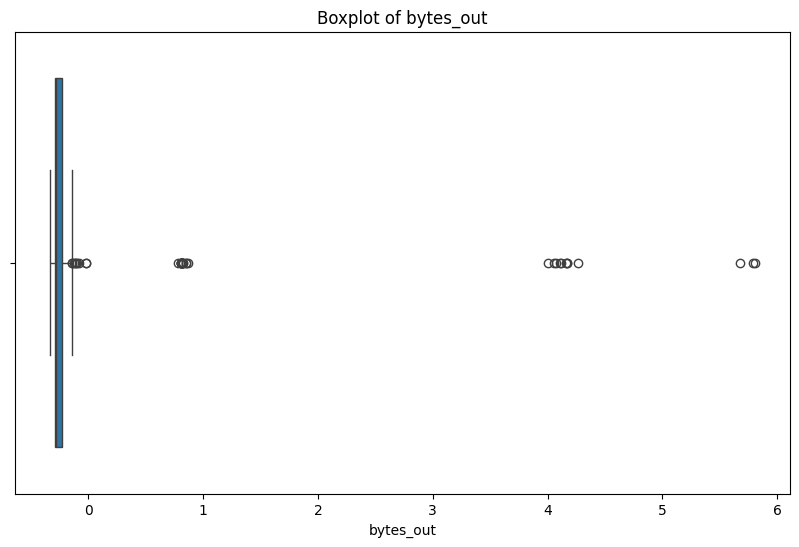

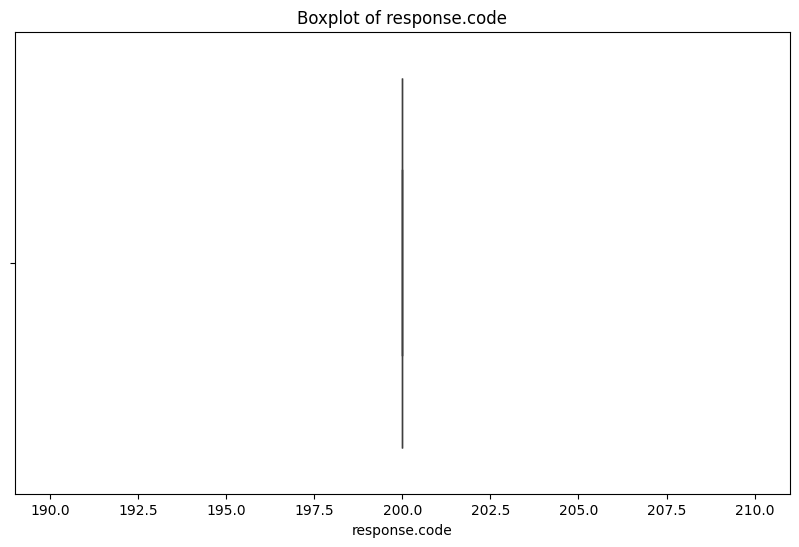

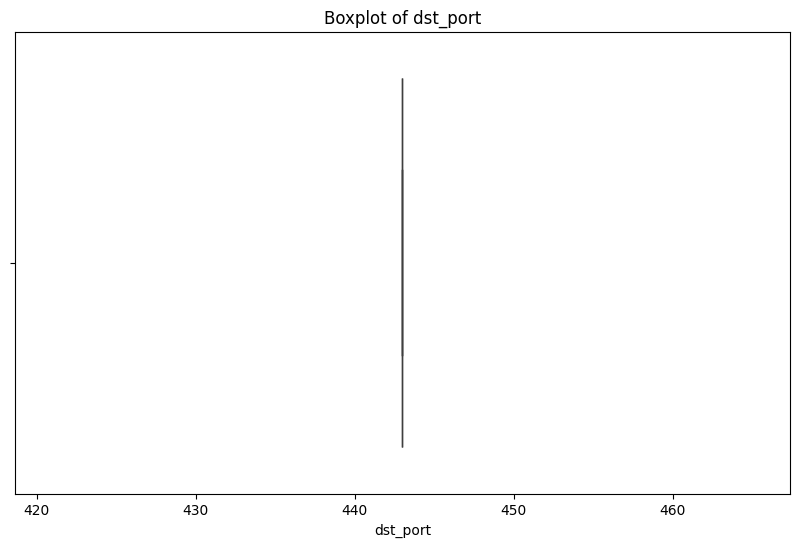

In [ ]:
# Boxplots for detecting outliers
for col in numeric_cols:
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=df[col])
  plt.title(f"Boxplot of {col}")
  plt.show()

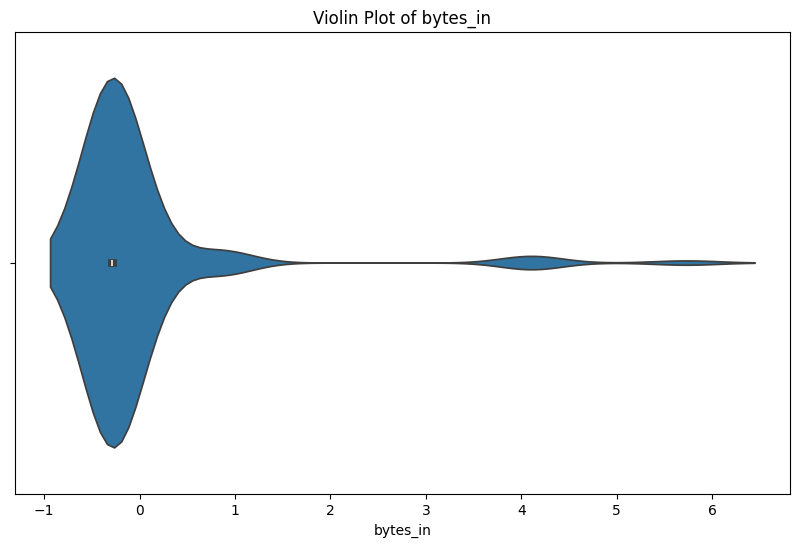

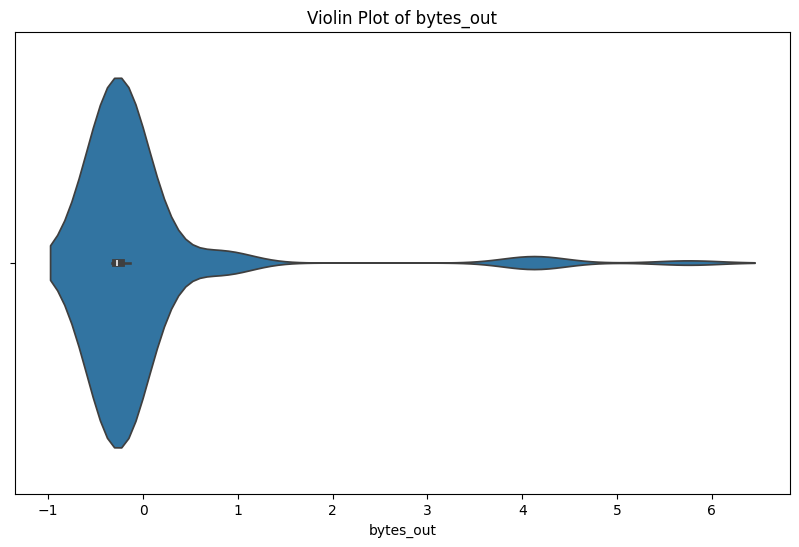

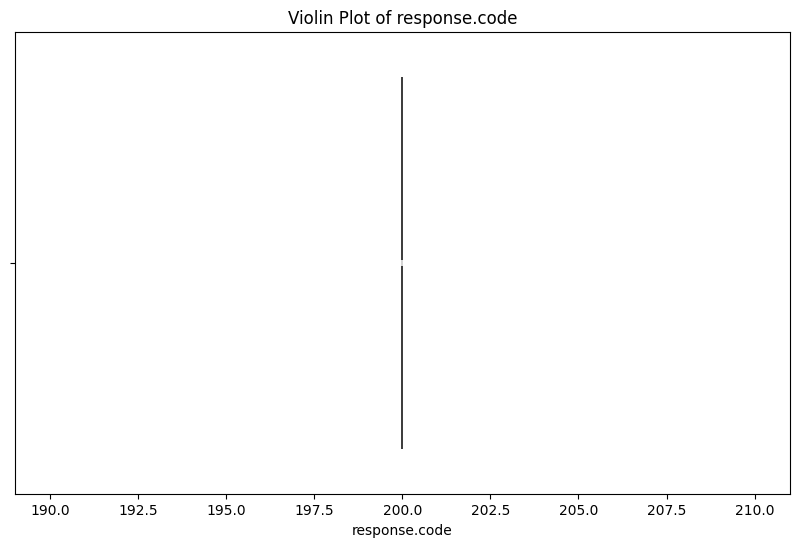

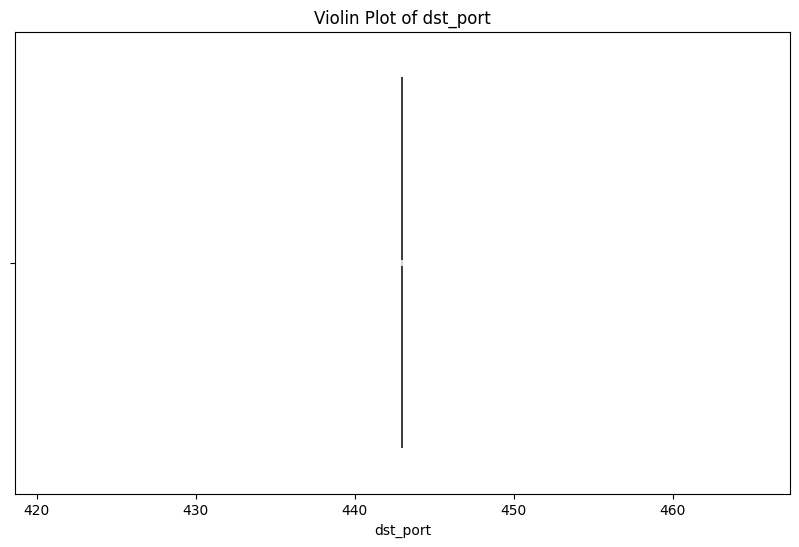

In [ ]:
# Violin plots for distribution visualization
for col in numeric_cols:
  plt.figure(figsize=(10, 6))
  sns.violinplot(x=df[col])
  plt.title(f"Violin Plot of {col}")
  plt.show()

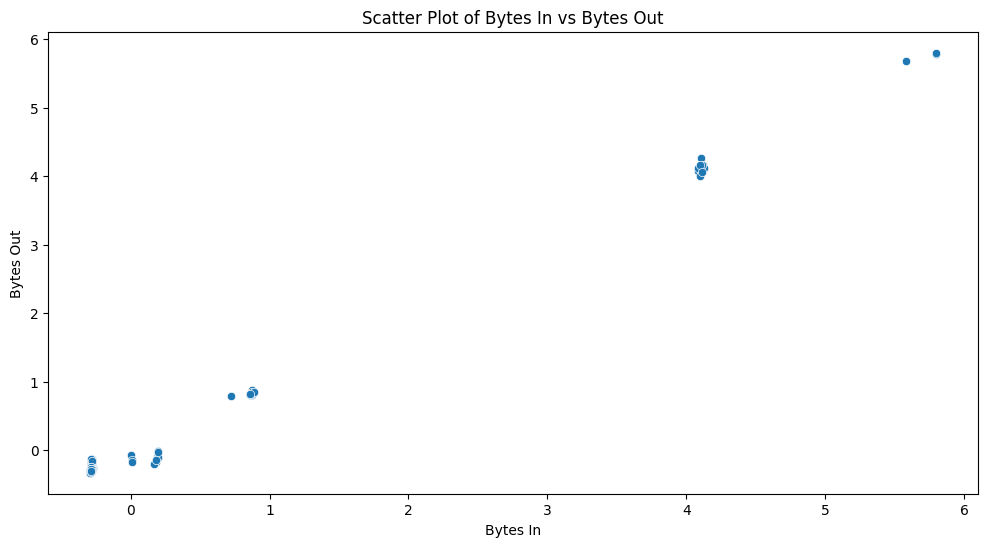

In [ ]:
# Scatter plots for relationship analysis between key features
if 'bytes_in' in df.columns and 'bytes_out' in df.columns:
  plt.figure(figsize=(12, 6))
  sns.scatterplot(x=df['bytes_in'], y=df['bytes_out'])
  plt.title("Scatter Plot of Bytes In vs Bytes Out")
  plt.xlabel("Bytes In")
  plt.ylabel("Bytes Out")
  plt.show()

**Modeling: Anomaly Detection**

Isolation Forest:
* Based on decision trees, it isolates anomalies because they are rare and differ significantly from normal data.
* Detection: Assigns each data point a score based on how easy it is to isolate. Points that are isolated faster are marked as anomalies. It labels anomalies as 1 and normal instances as 0.

Local Outlier Factor:
* LOF Calculates the density of each data point relative to its neighbors.
* If a data point has much lower density than its neighbors, it is considered as anomaly. This labels anomalies as 1 and normal points as 0.

In [ ]:
# Drop Unnecessary Columns
drop_cols = ['src_ip', 'dst_ip', 'creation_time', 'end_time', 'time', 'source.meta', 'source.name']
df_cleaned = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')


In [ ]:
# Identify categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

In [ ]:
# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
  le = LabelEncoder()
  df_cleaned[col] = le.fit_transform(df_cleaned[col])
  label_encoders[col] = le

In [ ]:
# Identify numerical columns after encoding
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# Normalize only numeric features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[numerical_cols]), columns=numerical_cols)

In [ ]:
# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_scaled["Anomaly_IF"] = iso_forest.fit_predict(df_scaled)

In [ ]:
# Anamoly detection using Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df_scaled["Anomaly_LOF"] =lof.fit_predict(df_scaled)

In [ ]:
# Convert anomaly labels:
df_scaled["Anomaly_IF"] = df_scaled["Anomaly_IF"].apply(lambda x: 1 if x== -1 else 0)
df_scaled["Anomaly_LOF"] = df_scaled["Anomaly_LOF"].apply(lambda x: 1 if x == -1 else 0)

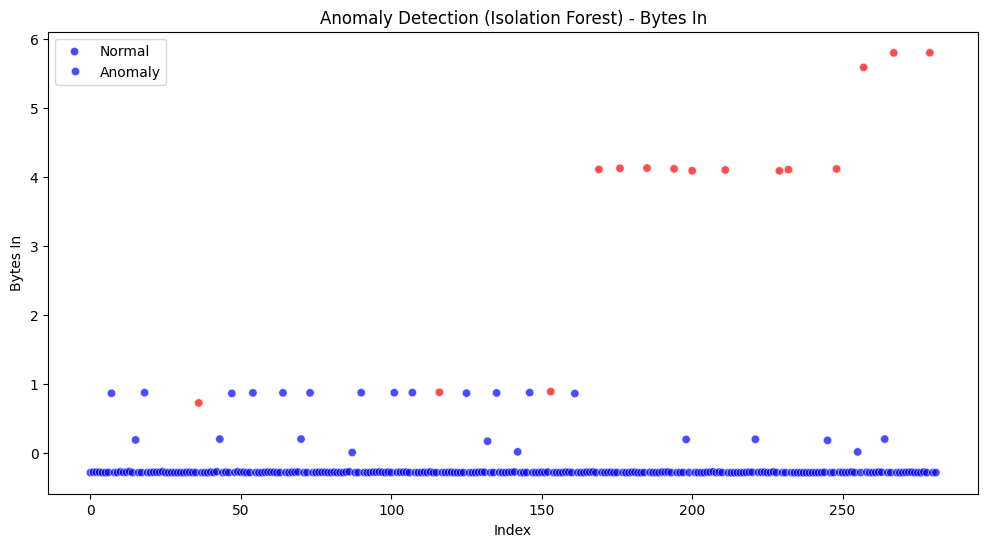

In [ ]:
# Visualizing Anomalies in network traffic
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_scaled.index, y=df_scaled['bytes_in'], hue=df_scaled["Anomaly_IF"], palette={0: "blue", 1: "red"}, alpha=0.7)
plt.title("Anomaly Detection (Isolation Forest) - Bytes In")
plt.xlabel("Index")
plt.ylabel("Bytes In")
plt.legend(["Normal", "Anomaly"])
plt.show()

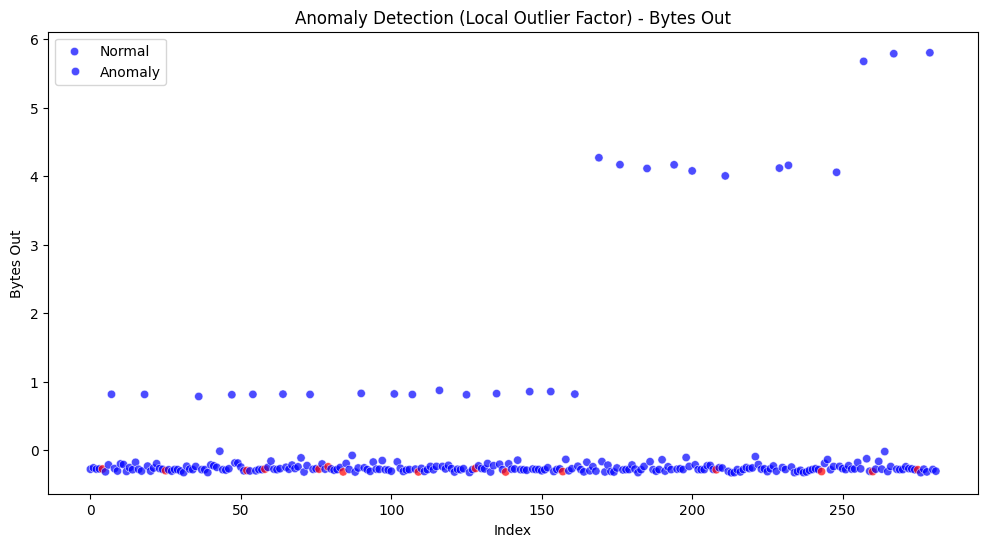

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_scaled.index, y=df_scaled['bytes_out'], hue=df_scaled["Anomaly_LOF"], palette={0: "blue", 1: "red"}, alpha=0.7)
plt.title("Anomaly Detection (Local Outlier Factor) - Bytes Out")
plt.xlabel("Index")
plt.ylabel("Bytes Out")
plt.legend(["Normal", "Anomaly"])
plt.show()

Anomalies are detected in two-key traffic metrics:
  * Anomalies in Incoming data (Bytes_in) using Isolation Forest.
  * Anomalies in Outgoing data (Bytes_out) using Local Outlier Factor.


Visualization:
  * Scatterplots highlight anomalies in red, showing unusual spikes or deviations.
  * Helps in identifying traffic spikes that may indicate security threats.

In [ ]:
# Print number of detected anomalies
print("Anomalies detected by Isolation Forest:", df_scaled["Anomaly_IF"].sum())
print("Anomalies detected by Local Outlier Factor:", df_scaled["Anomaly_LOF"].sum())

Anomalies detected by Isolation Forest: 15
Anomalies detected by Local Outlier Factor: 15


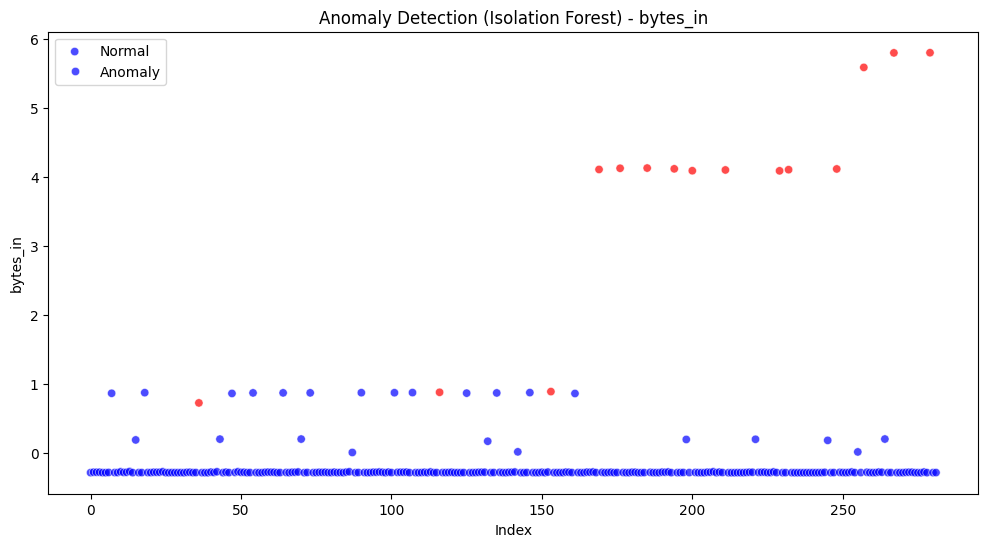

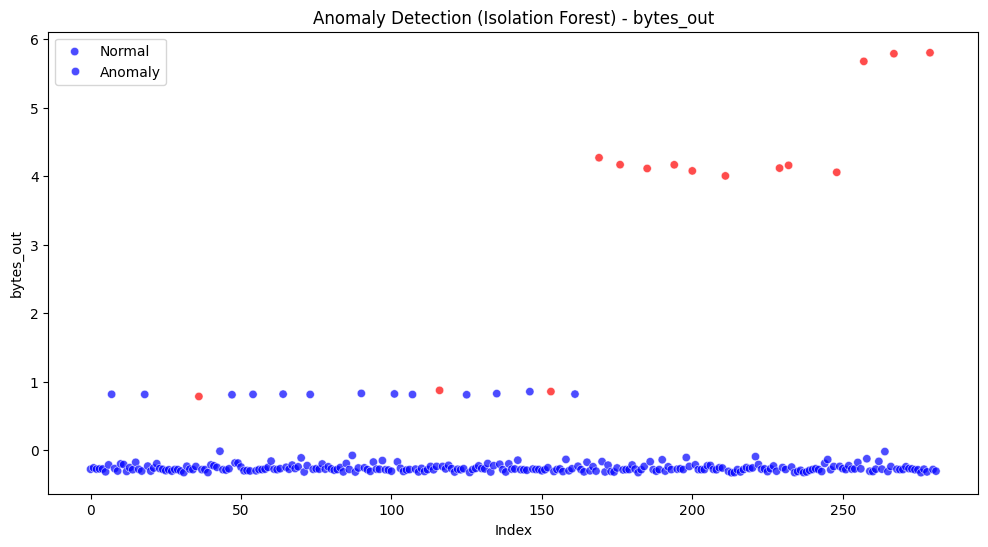

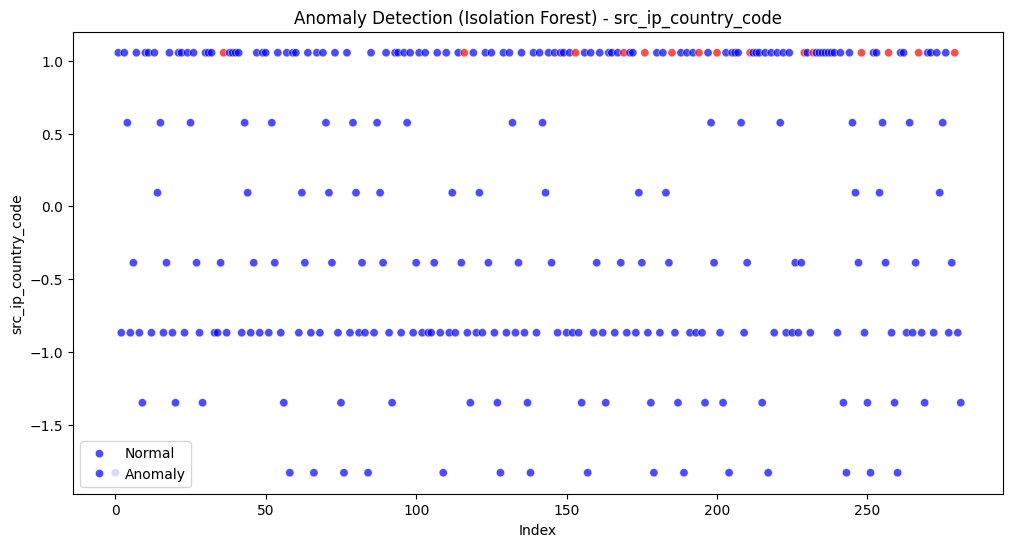

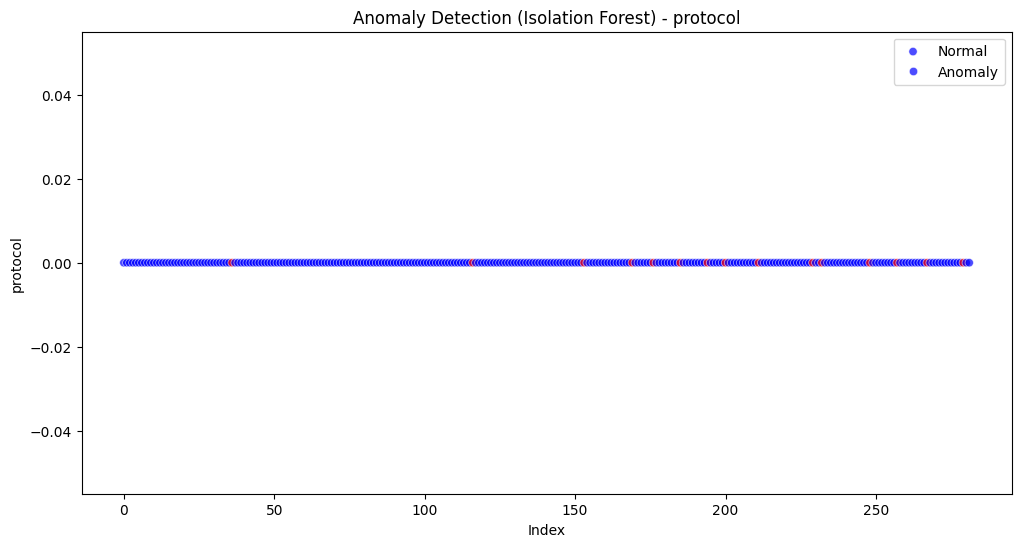

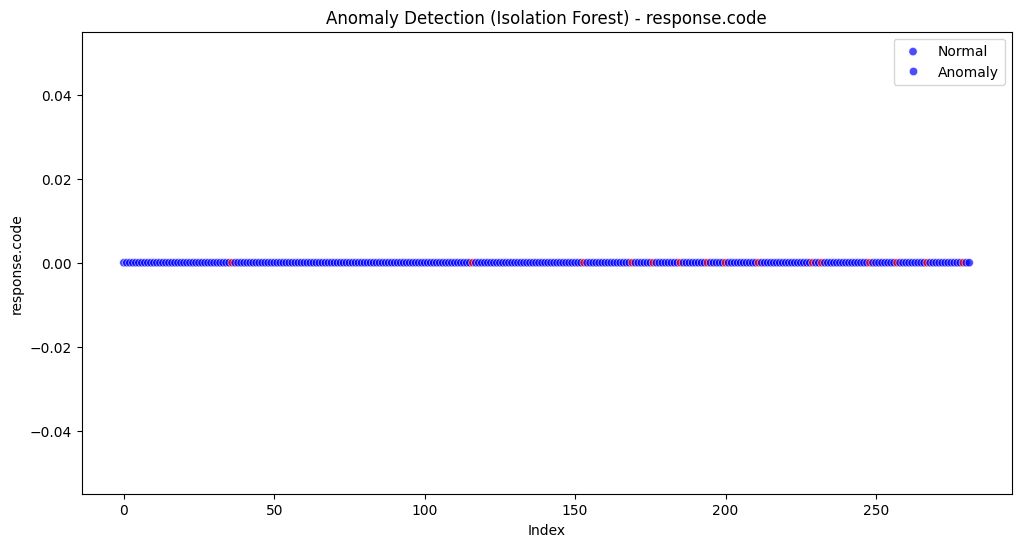

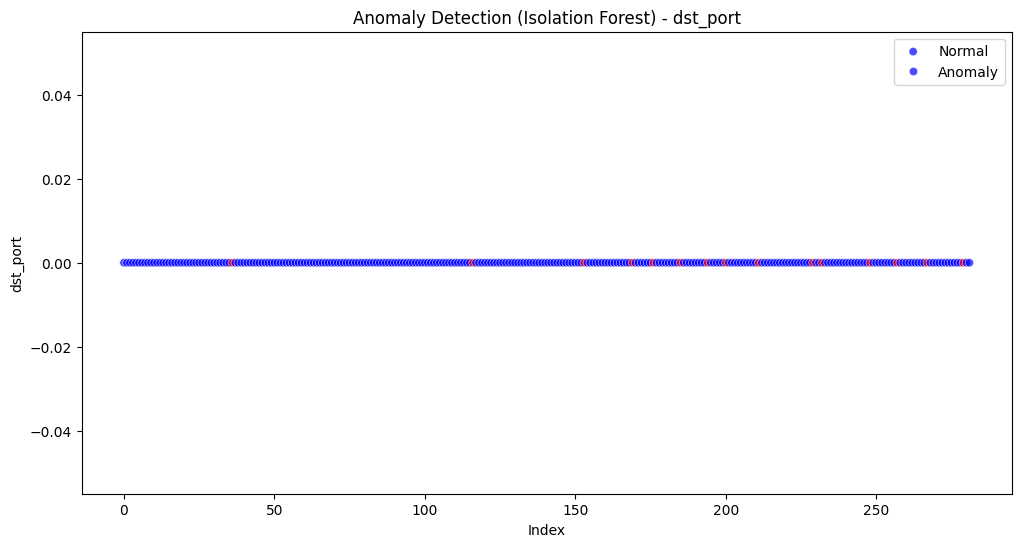

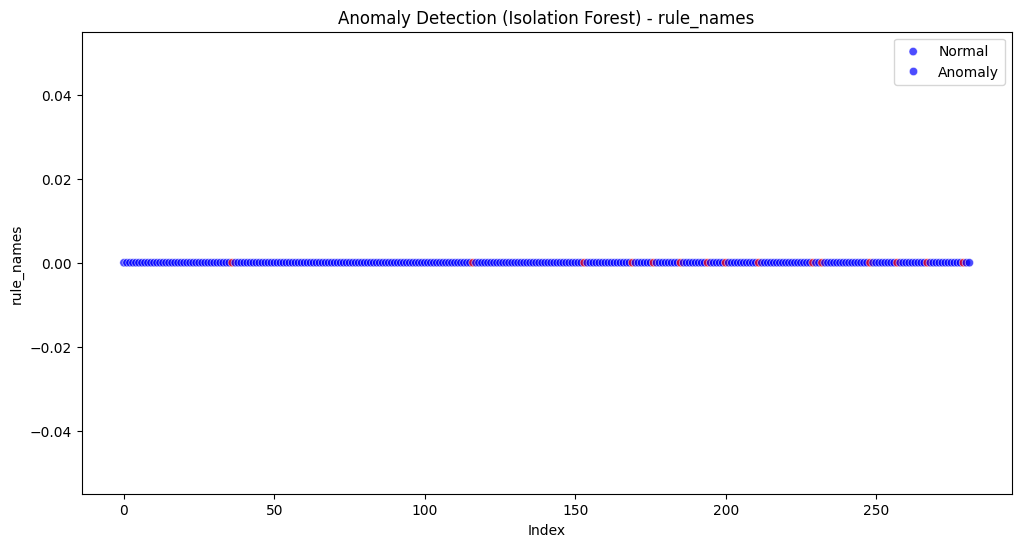

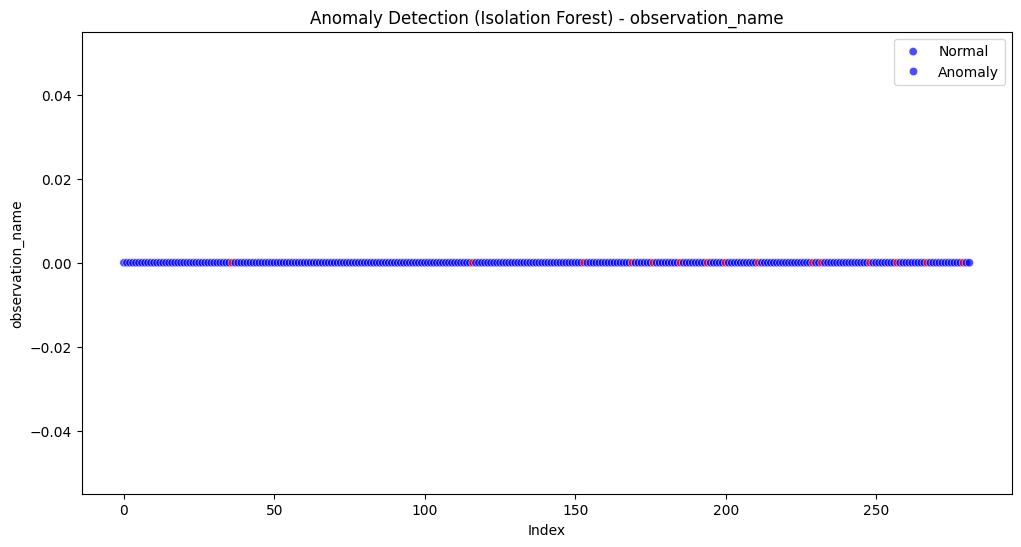

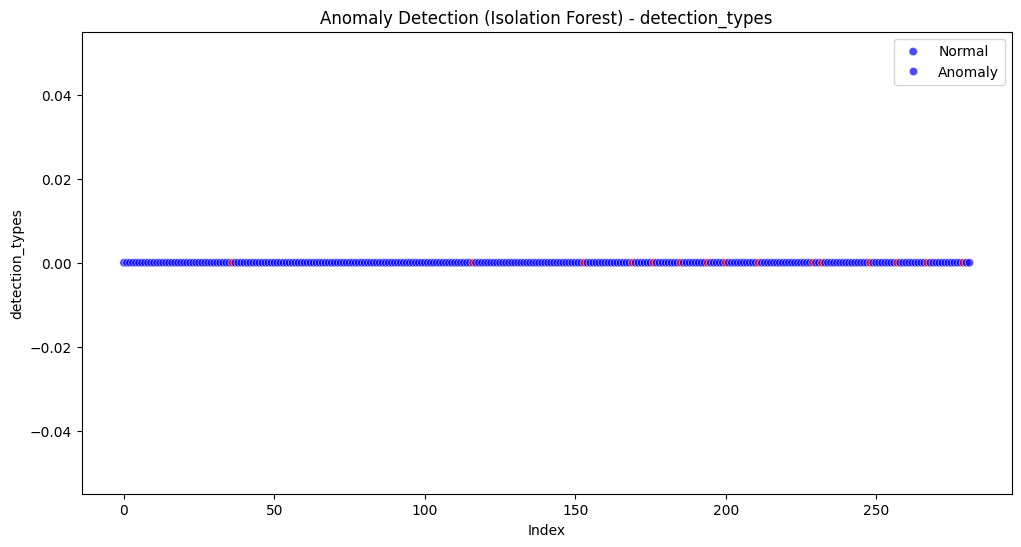

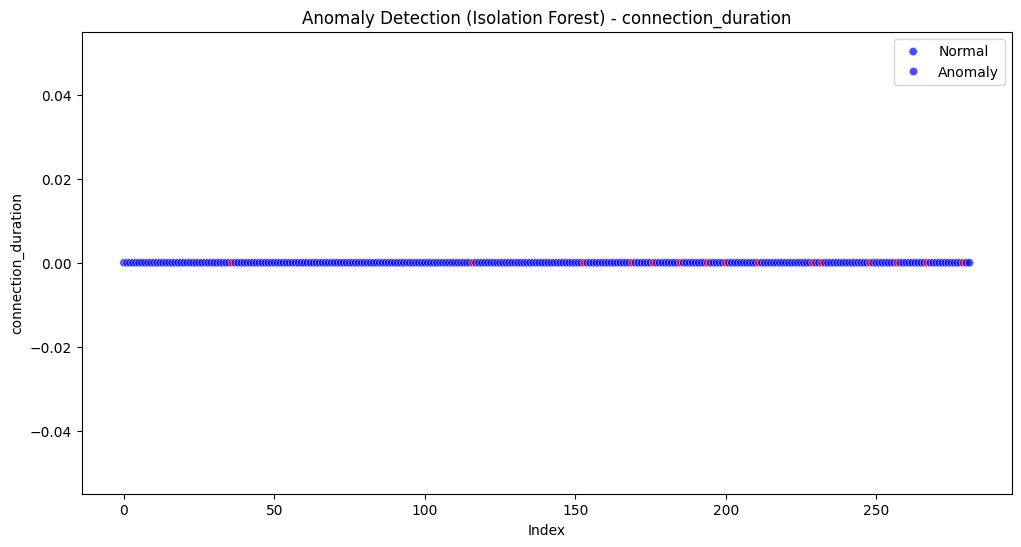

In [ ]:
# Visualizing Annomalies in other features
for feature in numerical_cols:
  plt.figure(figsize=(12, 6))
  sns.scatterplot(x=df_scaled.index, y=df_scaled[feature], hue=df_scaled["Anomaly_IF"], palette={0: "blue", 1: "red"}, alpha=0.7)
  plt.title(f"Anomaly Detection (Isolation Forest) - {feature}")
  plt.xlabel("Index")
  plt.ylabel(feature)
  plt.legend(["Normal", "Anomaly"])
  plt.show()

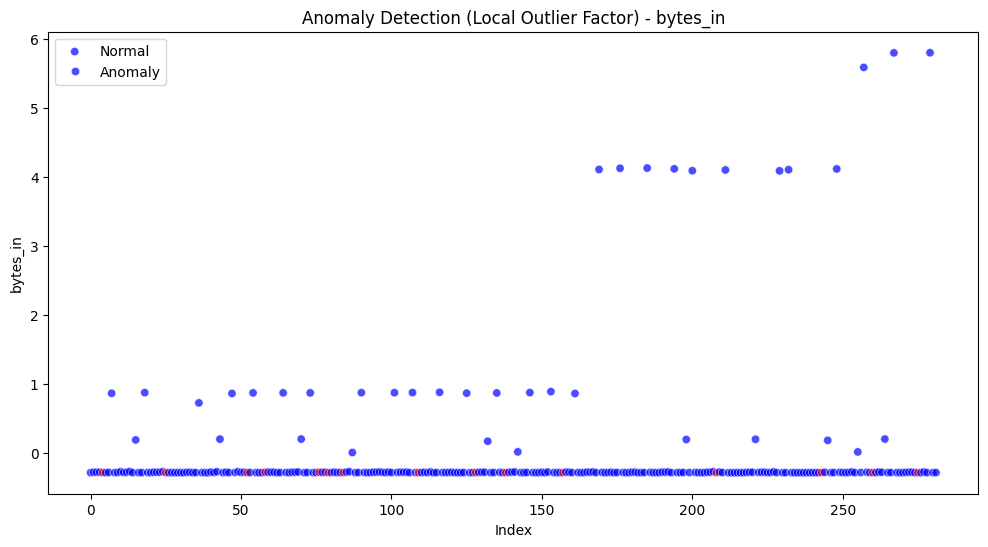

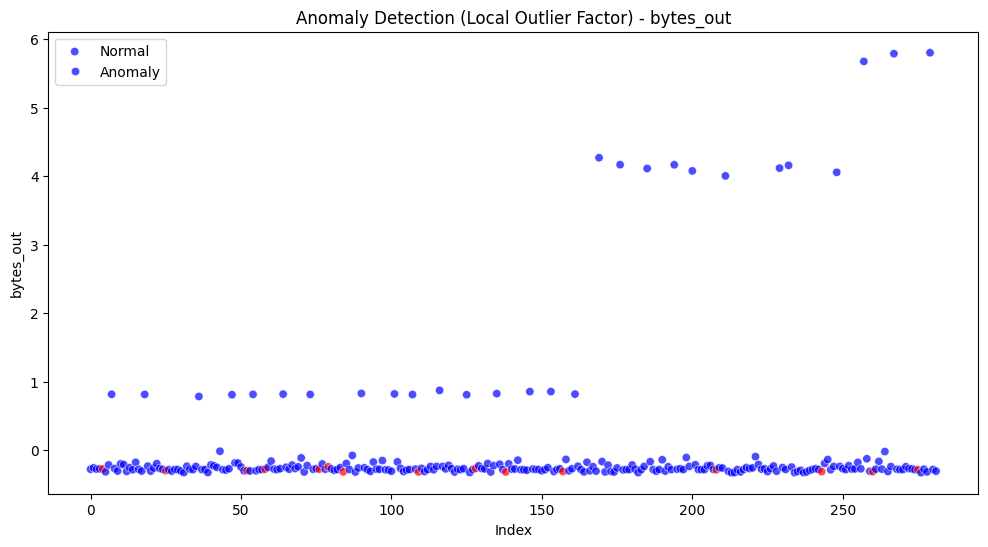

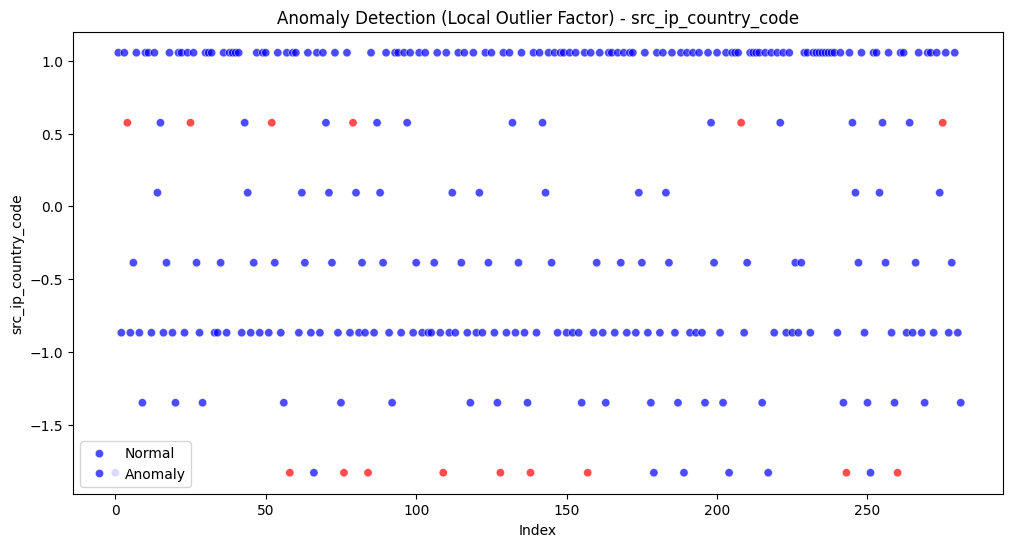

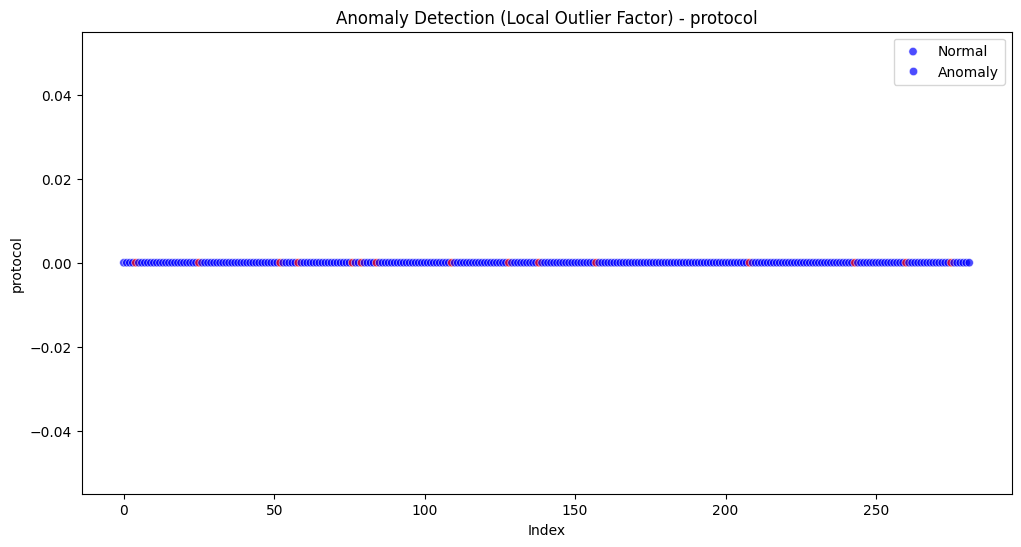

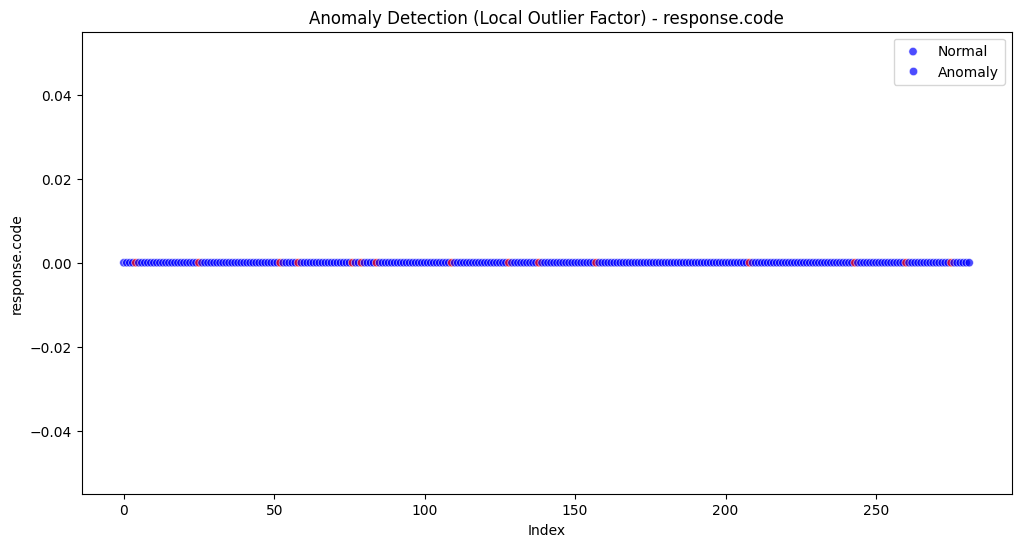

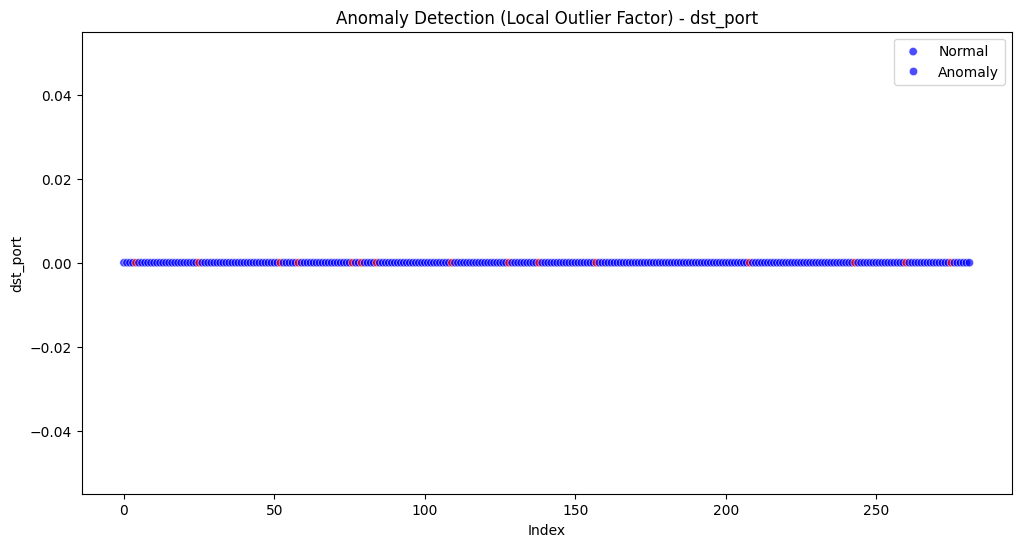

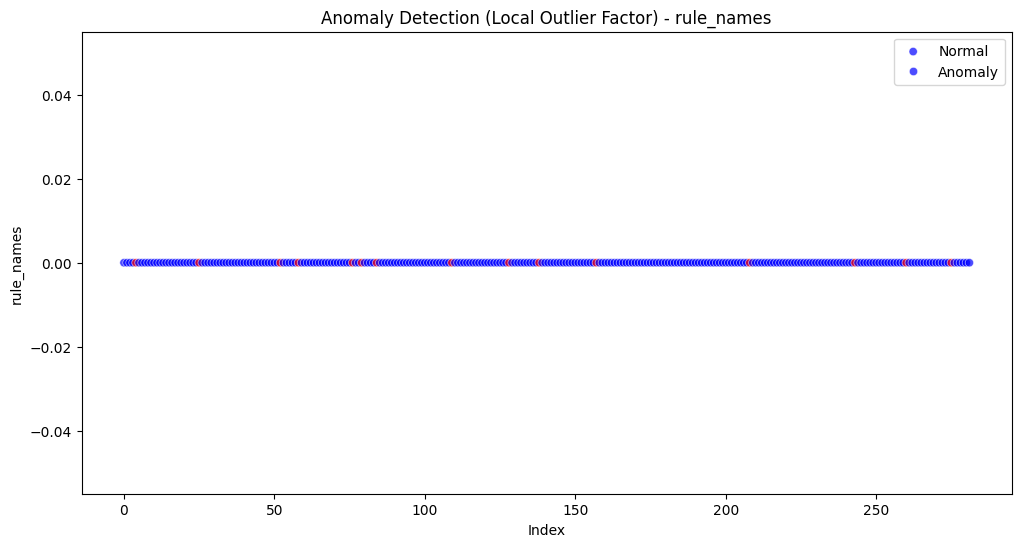

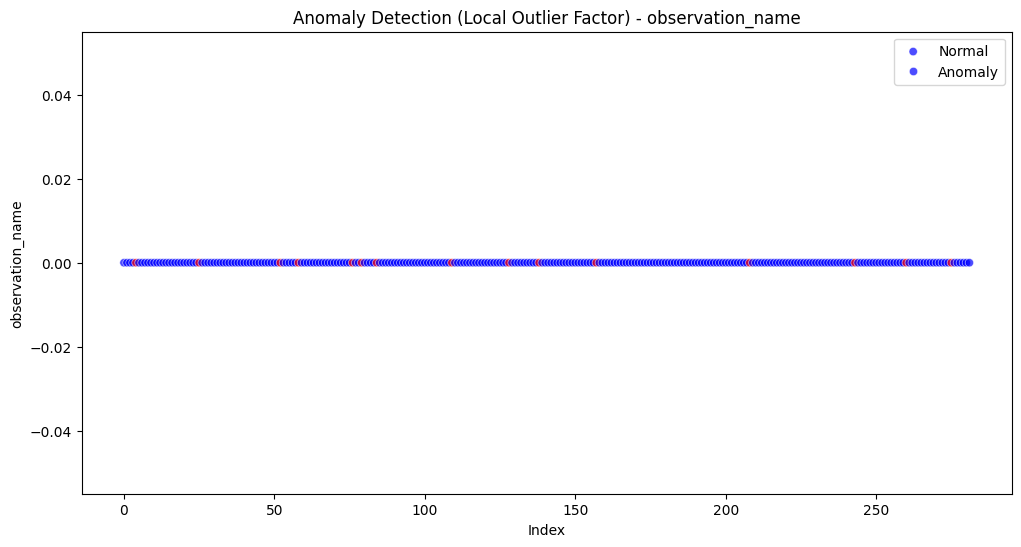

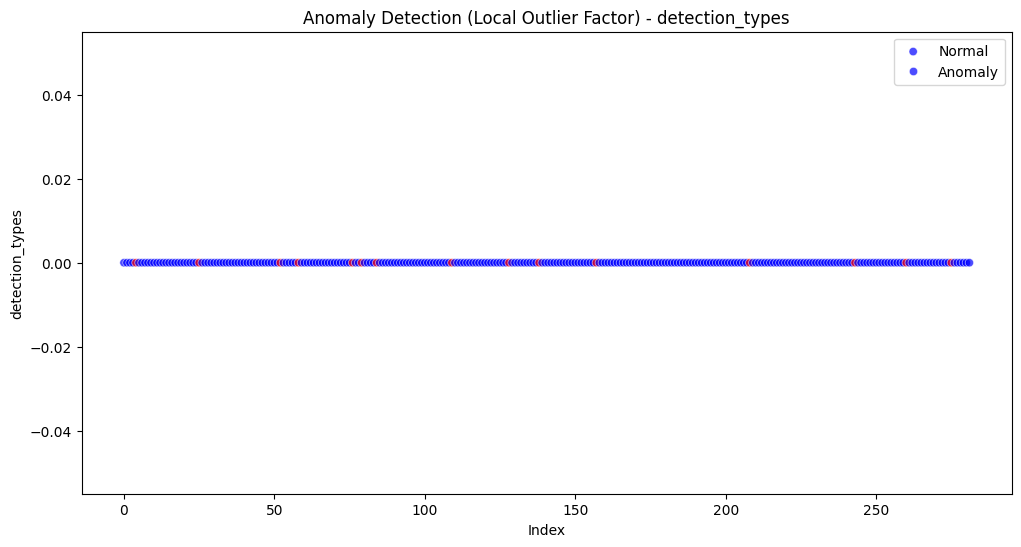

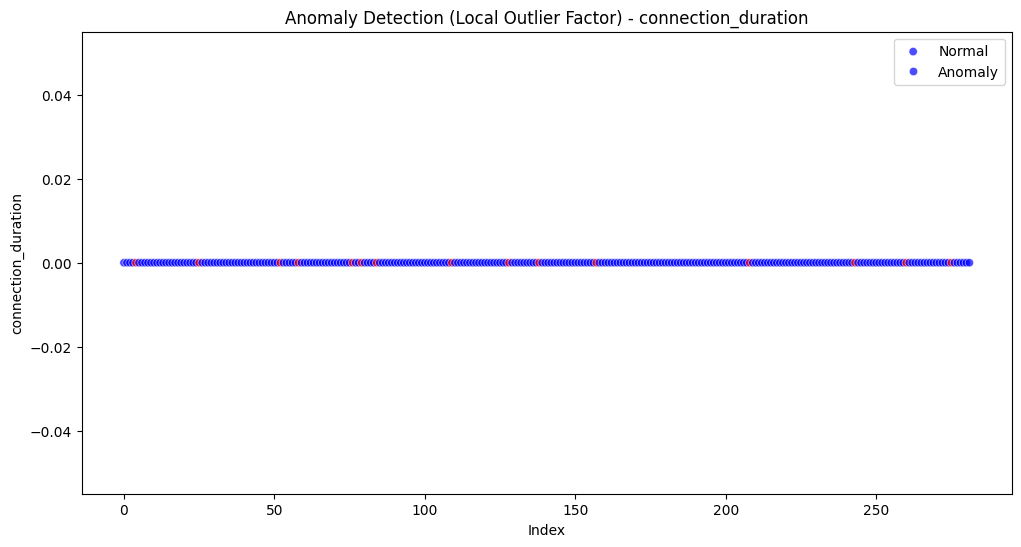

In [ ]:
for feature in numerical_cols:
  plt.figure(figsize=(12, 6))
  sns.scatterplot(x=df_scaled.index, y=df_scaled[feature], hue=df_scaled["Anomaly_LOF"], palette={0: "blue", 1: "red"}, alpha=0.7)
  plt.title(f"Anomaly Detection (Local Outlier Factor) - {feature}")
  plt.xlabel("Index")
  plt.ylabel(feature)
  plt.legend(["Normal", "Anomaly"])
  plt.show()

* Potential DDoS Attack Patterns: Large spikes in bytes_in and bytes_out suggest possible Denial-of-Service(DoS) attempts.
* Unusual Traffic Behavior: Certain IPs sent significantly more requests than average, indicating potential bit activity.
* High-Risk Requests: Anomalies detected  in response_size and request_count could indicate data exfiltarion or unauthorized access.

In [ ]:
# Print the number of detected anomalies
print("Anomalies detected by Isolation Forest:", df_scaled["Anomaly_IF"].sum())
print("Anomalies detected by Local Outlier Factor:", df_scaled["Anomaly_LOF"].sum())

Anomalies detected by Isolation Forest: 15
Anomalies detected by Local Outlier Factor: 15


**AutoEncoders for Anomaly detection:**

Autoencoder, a type of deep learning model, to detect anomalies in network traffic data. The Autoencoder was trained on nomral network traffic to learn patterns and reconstruct data efficiently. Any deviation from these learned patterns was flagged as an anomal, indicating potential security threats or irregular behavior.

In [ ]:
# Drop non-numeric columns
drop_cols = ['src_ip', 'dst_ip', 'creation_time', 'end_time', 'time', 'source.meta', 'source.name']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

In [ ]:
# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
  le = LabelEncoder()
  df_cleaned[col] = le.fit_transform(df_cleaned[col])
  label_encoders[col] = le

In [ ]:
# Identify numerical columns after encoding
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
for col in df.select_dtypes(include=['object']).columns:
  df[col] = LabelEnocder().fit_transform(df[col])


In [ ]:
# Normalize only numeric features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[numerical_cols]), columns=numerical_cols)

In [ ]:
# Define Autoencoder model
input_dim = df_scaled.shape[1]

autoencoder = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Train autoencoder on normal data
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.4782 - val_loss: 0.8073
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4551 - val_loss: 0.7907
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4779 - val_loss: 0.7660
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4273 - val_loss: 0.7382
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4356 - val_loss: 0.7061
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4063 - val_loss: 0.6715
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4207 - val_loss: 0.6325
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3319 - val_loss: 0.5874
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2978 - val_loss: 0.5384
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2363 - val_loss: 0.4969
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2200 - val_loss: 0.4699
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1855 - val_loss: 0.4543


**Reconstruction Error**: Measures the difference between input and reconstructed output.

**Threshold Setting:** Set the threshold at the 95th percentile of reconstruction errors. If any traffic data above this threshold was labeled as an anomaly.


In [ ]:
# Get reconstruction errors
reconstructed_data = autoencoder.predict(df_scaled)
reconstruction_error = np.mean(np.abs(reconstructed_data - df_scaled), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
# Set anomaly threshold
threshold =np.percentile(reconstruction_error, 95)
df['Anomaly_AE'] = (reconstruction_error > threshold).astype(int)

* High reconstruction errors were observed in traffic data where bytes_in and bytes_out had unusual spikes.
* Certain IPs shoed repeated anomalies, potentially indicating DDoS attacks or unauthorized access attempts.
* Irregualr request-response sizes led to anomaly detection, suggesting data exfiltration risks.

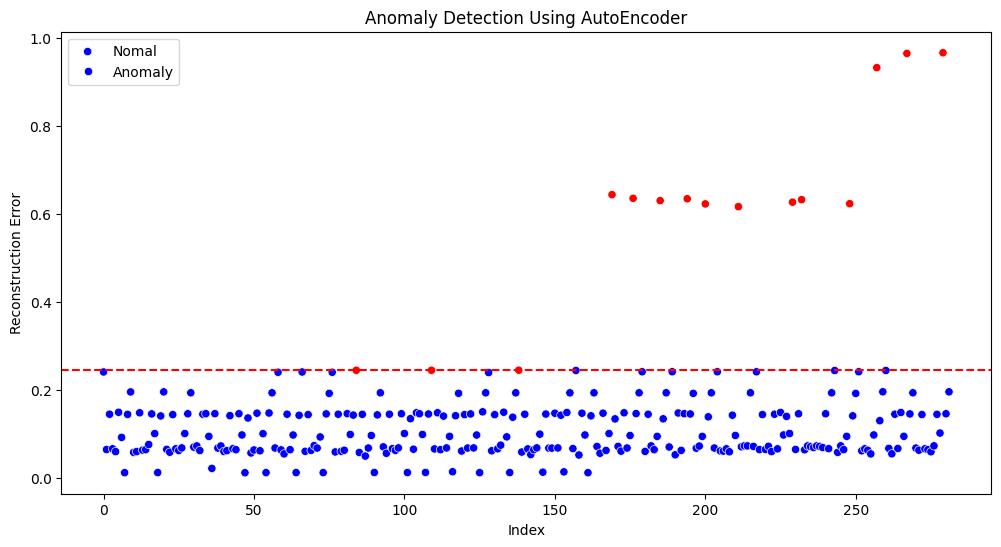

In [ ]:
# Visulaization of Anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df.index, y=reconstruction_error, hue=df['Anomaly_AE'], palette={0: "blue", 1:"red"})
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend(["Nomal", "Anomaly"])
plt.title("Anomaly Detection Using AutoEncoder")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

* A scatterplot of reconstruction errors showed that normal traffic had low errors(blue), with anomalous had high errors(red).
* the 95th percentile threshold effectively seperated normal vs anomalous points.

In [ ]:
# Print total anomalies detected
print("Total Anomalies Detected:", df["Anomaly_AE"].sum())

Total Anomalies Detected: 15


**Conclusion**

The CloudWatch Traffic Web Attack dataset provides valuable insights into network traffic behavior, potential threats, and anomaly detection. By leveraging machine learning techniques, we successfully identified unusual patterns that may indicate cyber threats, such as DDoS attacks, unauthorized access, or data exfiltration attempts.

* Anomalies Detected: Using Isolation Forest and  Local Outlier Factor (LOF), we identified several irregular network activities in various traffic parameters.
* Potential Cyber Threats: Some traffic patterns suggest possible DDoS attacks, bot activity, or unauthorized data transfers.
* Network Performance Issues: Anomalies in request size, response time, and traffic volume may indicate server overload or inefficient load balancing.
* Autoencoder Analysis: Autoencoders effectively idnetified network anomalies, including potential security threats.  


